In [2]:
import torch
from torchvision import models, transforms
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from time import sleep
from picamera2 import Picamera2
from gpiozero import AngularServo


In [3]:
from datetime import datetime
import os

script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()

def log_message(message):
    log_path = os.path.join(script_dir, "shutdown_log.txt")
    with open(log_path, "a") as log_file:
        log_file.write(f"{datetime.now()}: {message}\n")

# Function to monitor system health
def monitor_system():
    temp = os.popen("vcgencmd measure_temp").readline()
    temp = float(temp.replace("temp=", "").replace("'C\n", ""))

    voltage = os.popen("vcgencmd measure_volts").readline()
    voltage = float(voltage.replace("volt=", "").replace("V\n", ""))

    throttled = os.popen("vcgencmd get_throttled").readline().strip()

    if temp > 80:  # Adjust threshold as needed
        log_message(f"High temperature warning: {temp}�C")

    if voltage < 4.8:  # Voltage drop threshold
        log_message(f"Low voltage warning: {voltage}V")

    if "0x50000" in throttled:
        log_message(f"Throttling detected: {throttled}")

In [4]:

model_load_path = 'model.pth'
model = models.resnet18(weights=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(model_load_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


/home/teamuser/Documents/Project/sysvenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_4613/691548452.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer

In [5]:
def predict_image(image):
    image = image_transforms(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    
    class_names = ['organic', 'recyclable']
    prediction = class_names[preds.item()]
    return prediction

In [6]:
def capture_image():
    # Initialize the Picamera2 object
    picam2 = Picamera2()

    try:
        # Configure the camera resolution
        config = picam2.create_still_configuration(main={"size": (1024, 768)})
        picam2.configure(config)

        # Start the camera
        picam2.start()
        sleep(2)  # Allow the camera to warm up

        # Capture the image to a memory stream
        image_array = picam2.capture_array()
        image = Image.fromarray(image_array)

    finally:
        # Ensure the camera is stopped
        picam2.stop()
        picam2.close()

    return image

In [7]:
def runServo(perdiction):
    servo2=None
    servo1 = AngularServo(17,min_pulse_width=0.00075, max_pulse_width=0.00225)
    sleep(2)
    servo1.angle = 0
    sleep(2)
    if(perdiction != "organic"):
     servo2 = AngularServo(18,min_pulse_width=0.00075, max_pulse_width=0.00225)
     sleep(2)
     servo2.angle =0
     sleep(2)
    
    print("servos Initialized")

    while(True):
        if(perdiction == "organic"):

            sleep(3)
            servo1.angle = -45
            print(" servo1.angle = -45")
            sleep(3)
            servo1.angle = -0
            print(" servo1.angle = 0")
            sleep(3)
            servo1.detach()
            
        else:
          
            servo1.angle = 45
            sleep(3)
            servo1.angle = -45
            sleep(3)
            servo2.angle = -45
            sleep(3)
            servo2.angle = -0
            sleep(3)
            servo1.angle = 0
            sleep(3)
            servo1.angle = 0
            sleep(3)
            print(" servo1.angle = 0")
            servo1.detach()
            servo2.detach()
            
        break

    '''
    sleep(2)
    servo1.angle = 0
    sleep(2)
    if prediction == "organic":
        print(" servo1.angle = -45")
        servo1.angle = -45
        sleep(2)
        print(" servo1.angle = 0")
        servo1.angle= 0
    
    else:
        print(" servo1.angle = 45")
        servo1.angle = 45
        sleep(2)     
        print(" servo1.angle = 0")
        servo1.angle= 0
    '''



[1:10:52.791699242] [4768]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5
[1:10:52.807126131] [4782]  INFO RPI pisp.cpp:695 libpisp version v1.0.6 b567f0455680 17-06-2024 (10:20:00)
[1:10:52.822922186] [4782]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:10:52.826559982] [4768]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5
[1:10:52.840385001] [4785]  INFO RPI pisp.cpp:695 libpisp version v1.0.6 b567f0455680 17-06-2024 (10:20:00)
[1:10:52.855070019] [4785]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:10:52.857995445] [4768]  WARN V4L2 v4l2_pixelformat.cpp:344 Unsupported V4L2 pixel format RPBP
[1:10:52.858938538] [4768]  INFO Camera camera.cpp:1183 configuring streams: (0) 1024x768-BGR888 (1) 1640x

camera captured


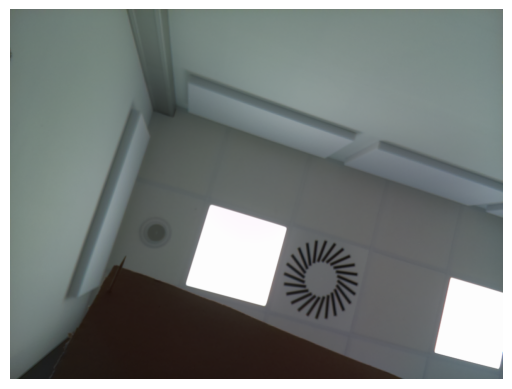

recyclable
servos Initialized
 servo1.angle = 0


[1:12:07.843112030] [4789]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5
[1:12:07.857099086] [4803]  INFO RPI pisp.cpp:695 libpisp version v1.0.6 b567f0455680 17-06-2024 (10:20:00)
[1:12:07.874240364] [4803]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:12:07.876246697] [4789]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5
[1:12:07.887598234] [4806]  INFO RPI pisp.cpp:695 libpisp version v1.0.6 b567f0455680 17-06-2024 (10:20:00)
[1:12:07.901789864] [4806]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:12:07.905560771] [4789]  WARN V4L2 v4l2_pixelformat.cpp:344 Unsupported V4L2 pixel format RPBP
[1:12:07.906737123] [4789]  INFO Camera camera.cpp:1183 configuring streams: (0) 1024x768-BGR888 (1) 1640x

camera captured


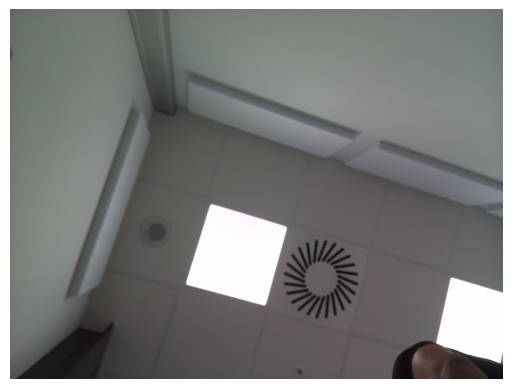

recyclable
servos Initialized
 servo1.angle = 0


[1:12:46.805031951] [4810]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5
[1:12:46.815570007] [4820]  INFO RPI pisp.cpp:695 libpisp version v1.0.6 b567f0455680 17-06-2024 (10:20:00)
[1:12:46.830581174] [4820]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:12:46.832722951] [4810]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5
[1:12:46.844174711] [4823]  INFO RPI pisp.cpp:695 libpisp version v1.0.6 b567f0455680 17-06-2024 (10:20:00)
[1:12:46.857283377] [4823]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:12:46.861028970] [4810]  WARN V4L2 v4l2_pixelformat.cpp:344 Unsupported V4L2 pixel format RPBP
[1:12:46.861896174] [4810]  INFO Camera camera.cpp:1183 configuring streams: (0) 1024x768-BGR888 (1) 1640x

camera captured


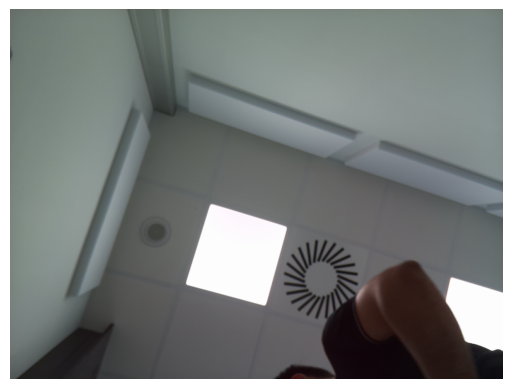

recyclable
servos Initialized
 servo1.angle = 0


[1:15:51.318782638] [4827]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5
[1:15:51.329747749] [4838]  INFO RPI pisp.cpp:695 libpisp version v1.0.6 b567f0455680 17-06-2024 (10:20:00)
[1:15:51.344303490] [4838]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:15:51.347531545] [4827]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5
[1:15:51.358760953] [4841]  INFO RPI pisp.cpp:695 libpisp version v1.0.6 b567f0455680 17-06-2024 (10:20:00)
[1:15:51.372555953] [4841]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[1:15:51.376284675] [4827]  WARN V4L2 v4l2_pixelformat.cpp:344 Unsupported V4L2 pixel format RPBP
[1:15:51.377122971] [4827]  INFO Camera camera.cpp:1183 configuring streams: (0) 1024x768-BGR888 (1) 1640x

camera captured


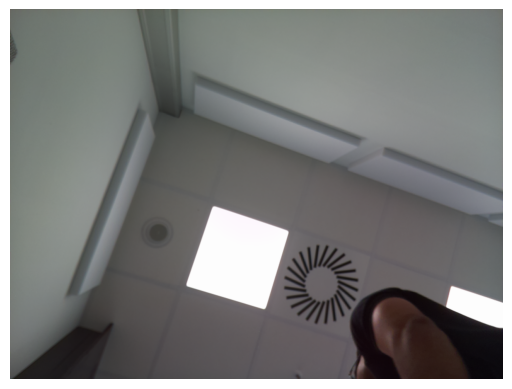

recyclable
servos Initialized
 servo1.angle = 0


In [10]:
if __name__ == "__main__":
    while True:

        monitor_system()
        
        
        captured_image = capture_image()
        print("camera captured")
        plt.imshow(captured_image)
        plt.axis('off')
        plt.show()
        prediction = predict_image(captured_image)
        print(prediction)
        runServo(prediction)
        # Ask the user if they want to capture another image
        user_input = input("Capture another image? (y/n): ")
        if user_input.lower() != 'y':
            break